This Jupyter notebook contains the code to perform simulations for the mini project at C6.5 Theories of Deep Learning 

In [187]:
## Inital Setup

In [188]:
import tensorflow as tf
import random
import copy
import matplotlib.pyplot as plt
import time
from gsam import GSAM 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

For the first test we will use the scikit learn 2 moons dataset to demonstrate the differences between GSAM and Adaptive-GSAM performance.

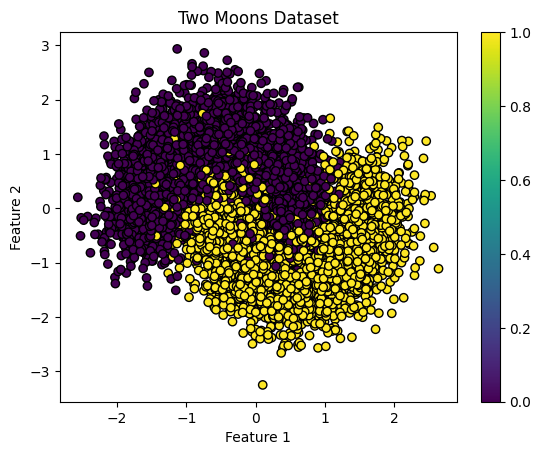

In [189]:
# Load the Two Moons dataset
X, y = make_moons(n_samples=10000, noise=0.3, random_state=10)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data (feature scaling to ensure better convergence)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Plot the first two features for visualization (make sure to use the same samples for color mapping)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Two Moons Dataset')
plt.colorbar()  # To show the color bar
plt.show()

We use an overparamaterised ReLU network

In [190]:
# Define the model
model = Sequential([
    Flatten(input_shape=(2, )),  
    Dense(32, activation='relu'),   
    Dense(32, activation='relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation='sigmoid'), 
])

# Summary of the model
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_22 (Flatten)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Here we create a function for training

In [191]:
# Training function
def train_model_with_gsam(model, use_gsam=True):
    # Create the GSAM model if specified
    if use_gsam:
        gsam_model = GSAM(model, adaptive = True)
    else:
        gsam_model = GSAM(model, adaptive = False)
    
    gsam_model.compile(
        optimizer='SGD',  # You can use the standard SGD or any optimizer you want
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print the total learnable parameters in millions
    print(f"Total learnable parameters: {gsam_model.model.count_params() / 1e6} M")

    # Train the model
    start = time.time()
    history = gsam_model.fit(
        x_train, y_train, epochs=50, batch_size=64, 
        validation_data=(x_test, y_test), 
    )

    # Evaluate the model on the test set
    test_loss, test_acc = gsam_model.evaluate(x_test, y_test)

    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")
    print(f"Total training time: {(time.time() - start) / 60.} minutes")

    return history

Now we train two models, one with vanilla GSAM and one with adaptive GSAM

In [192]:
print("Training with Adaptive-GSAM...")
history_gsam_adaptive = train_model_with_gsam(copy.deepcopy(model),True)

# Training with GSAM(False)
print("Training with Vanilla-GSAM...")
history_gsam_vanilla = train_model_with_gsam(copy.deepcopy(model),False)

Training with Adaptive-GSAM...
Total learnable parameters: 0.002241 M
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:664: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:639: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3654 - loss: 0.4837 - val_accuracy: 0.7857 - val_loss: 0.6216
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7678 - loss: 0.4827 - val_accuracy: 0.8347 - val_loss: 0.5477
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.4777 - val_accuracy: 0.8513 - val_loss: 0.4636
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8264 - loss: 0.4742 - val_accuracy: 0.8560 - val_loss: 0.3951
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8351 - loss: 0.4739 - val_accuracy: 0.8540 - val_loss: 0.3609
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8366 - loss: 0.4891 - val_accuracy: 0.8560 - val_loss: 0.3481
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8413 - loss: 0.4974 - val_accuracy: 0.8573 - val_loss: 0.3437
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8356 - loss: 0.5050 - val_accuracy: 0.8580 - val_

Now we plot a comparison between the two models

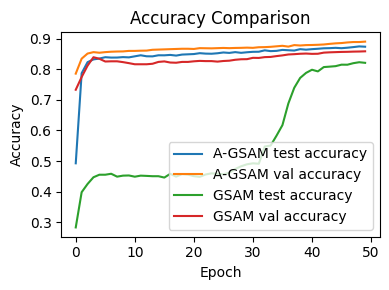

In [193]:
plt.figure(figsize=(4, 3))

# Accuracy Plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.plot(history_gsam_adaptive.history['accuracy'][:], label='A-GSAM test accuracy')
plt.plot(history_gsam_adaptive.history['val_accuracy'][:], label='A-GSAM val accuracy')
plt.plot(history_gsam_vanilla.history['accuracy'][:], label='GSAM test accuracy')
plt.plot(history_gsam_vanilla.history['val_accuracy'][:], label='GSAM val accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
m